# 🏍️ LossZero: Motorcycle Night Ride SegFormer-B2 Optimized

이 노트북은 **SegFormer-B2** 모델을 사용하여 야간 오토바이 주행 이미지의 시멘틱 세그멘테이션을 수행합니다.

### 🛠️ 주요 시나리오
- **모델**: SegFormer-B2 (Transformer 기반)
- **백본**: MiT-B2
- **사전 학습**: Cityscapes (도로 환경 특화)
- **최적화**: AdamW + FP16 Mixed Precision
- **손실 함수**: Weighted CrossEntropy (중요 객체 가중치 부여)

In [65]:
import os
import cv2
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from pycocotools.coco import COCO
import albumentations as A
from albumentations.pytorch import ToTensorV2
from transformers import SegformerForSemanticSegmentation, SegformerConfig
from torch.amp import autocast, GradScaler
from tqdm.auto import tqdm
import wandb
import torch.nn.functional as F

# 🐒 [MPS COMPATIBILITY PATCH - V2 SAFE]
if not hasattr(torch, '_mps_patched'):
    print("🚀 Applying MPS compatibility monkey-patch...")
    
    # [1] torch.cat 패치
    _orig_cat = torch.cat
    def patched_cat(tensors, dim=0, *args, **kwargs):
        if any(t.device.type == 'mps' for t in tensors):
            tensors = [t.contiguous() for t in tensors]
        return _orig_cat(tensors, dim=dim, *args, **kwargs)
    torch.cat = patched_cat

    # [2] F.interpolate 패치
    _orig_interpolate = F.interpolate
    def patched_interpolate(input, size=None, scale_factor=None, mode='nearest', *args, **kwargs):
        if torch.is_tensor(input) and input.device.type == 'mps':
            input = input.contiguous()
        return _orig_interpolate(input, size=size, scale_factor=scale_factor, mode=mode, *args, **kwargs)
    F.interpolate = patched_interpolate
    
    torch._mps_patched = True
    print("✅ MPS patch applied successfully.")
else:
    print("ℹ️ MPS patch is already active.")

print(f"PyTorch version: {torch.__version__}")


ℹ️ MPS patch is already active.
PyTorch version: 2.6.0


In [66]:
import os
# 🚀 MPS 메모리 할당 제한 해제 및 캐시 정리
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"
import torch
if torch.backends.mps.is_available():
    torch.mps.empty_cache()

def get_device():
    if torch.cuda.is_available():
        return "cuda"

    if torch.backends.mps.is_available():
        return "mps"
        
    return "cpu"

def num_worker():
    if torch.cuda.is_available():
        return os.cpu_count()

    return 0

# ⚙️ 설정 (Configuration)
# DATA_DIR = "/content/drive/MyDrive/motor_model"
# DATA_DIR = "/home/jovyan/work/motorcycle/Dataset"
# DATA_DIR = "/home/jovyan/work/data/LossZero"
DATA_DIR = os.path.expanduser("~/Projects/LossZero/data/Motorcycle Night Ride Dataset")
print("Detected Local Environment")

JSON_PATH = os.path.join(DATA_DIR, "COCO_motorcycle (pixel).json")
IMG_DIR = os.path.join(DATA_DIR, "images")

CFG = {
    "project": "LossZero",
    "model_name": "nvidia/segformer-b2-finetuned-cityscapes-1024-1024",
    "img_size": (416, 736),
    "batch_size": 4, # Reduced for MPS memory stability
    "lr": 1e-4,
    "epochs": 20,
    "device": get_device(),
    "num_worker": num_worker(),
    "train": True,
    "wndb": True,
}

if CFG["wndb"]:
    wandb.login()

print(f"Using device: {CFG['device']}")
print(f"Data directory: {DATA_DIR}")

Detected Local Environment
Using device: mps
Data directory: /Users/jamesyang/Projects/LossZero/data/Motorcycle Night Ride Dataset


In [67]:
def create_mask_from_json(coco, img_id, img_info, id_to_idx):
    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)
    mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)

    for ann in anns:
        cat_id = ann['category_id']
        if cat_id in id_to_idx:
            cls_idx = id_to_idx[cat_id]
            pixel_mask = coco.annToMask(ann)
            mask[pixel_mask == 1] = cls_idx

    return mask

def process_single_data(coco, img_id, img_dir, id_to_idx, transform=None):
    img_info = coco.loadImgs(img_id)[0]
    img_path = os.path.join(img_dir, img_info['file_name'])

    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = create_mask_from_json(coco, img_id, img_info, id_to_idx)

    if transform:
        augmented = transform(image=image, mask=mask)
        image, mask = augmented['image'], augmented['mask']

    return image, torch.as_tensor(mask).long()

train_transform = A.Compose([
    #  이미지 전체 구도 파악을 위해 Resize 적용 (Copy-Paste 효과 극대화)
    A.Resize(height=CFG['img_size'][0], width=CFG['img_size'][1], p=1.0),

    # --- 야간 전용 Augmentation 추가 ---
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.RandomGamma(gamma_limit=(80, 120), p=0.5), # 어두운 저조도 개선
    A.GaussNoise(std_range=(0.02, 0.05), p=0.3), # 야간 노이즈 대응

    # --- 기하학적 변형 (데이터 수 보충용) ---
    A.HorizontalFlip(p=0.5), # 좌우 반전
    # 0.0625는 머신러닝/딥러닝 커뮤니티에서 오랫동안 검증된 '사실상 표준(De Facto Standard)
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=25, p=0.5), # 이동/크기/회전

    # ImageNet 데이타셋의 평균값 나쁘지 않음. SegFormer가 ImageNet/Cityscapes로 배웠으니까
    # 모델이 새로운 사진을 받을 때: 입력_이미지 = (원본_이미지 - 평균) / 표준편차
    # 이렇게 계산해주면, 어떤 사진이 들어와도 "평균이 0이고 표준편차가 1인(Standard Normal Distribution)" 아주 예쁜 데이터로 변신
    # 전체 야간 데이터셋의 Mean/Std를 직접 계산한 값
    A.Normalize(mean=(0.281, 0.268, 0.346), std=(0.347, 0.290, 0.292)),
    ToTensorV2()
])

coco = COCO(JSON_PATH)
img_ids = list(coco.imgs.keys())
cat_ids = coco.getCatIds()
id_to_idx = {cat_id: i for i, cat_id in enumerate(cat_ids)}
print(f"Category Mapping: {id_to_idx}")

/Users/jamesyang/.pyenv/versions/3.12.2/envs/aipel/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


loading annotations into memory...
Done (t=1.19s)
creating index...
index created!
Category Mapping: {1329681: 0, 1323885: 1, 1323884: 2, 1323882: 3, 1323881: 4, 1323880: 5}


## Traing / Val 분리

In [68]:
import random
from sklearn.model_selection import train_test_split
class MotorcycleNightRideDataset(Dataset):
    def __init__(self, coco, img_ids, img_dir, id_to_idx, transform=None, use_copy_paste=False):
        self.coco = coco
        self.img_ids = img_ids
        self.img_dir = img_dir
        self.id_to_idx = id_to_idx
        self.transform = transform
        self.use_copy_paste = use_copy_paste  # Copy-Paste 활성화 여부 (Train만 True)

    def __len__(self):
        return len(self.img_ids)

    def load_image_mask(self, idx):
        """인덱스에 해당하는 이미지와 마스크를 로드하고 BGR->RGB 변환"""
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.img_dir, img_info['file_name'])

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # 마스크 생성 (기존 함수 활용)
        mask = create_mask_from_json(self.coco, img_id, img_info, self.id_to_idx)
        return image, mask

    def apply_copy_paste(self, image, mask):
        """
        Copy-Paste Augmentation:
        다른 이미지(Donor)에서 'Lane Mark(3)'나 'Moveable(2)' 같은 소수 클래스를 오려내어
        현재 이미지(Target)에 붙여넣습니다.
        """
        # 1. 기증자(Donor) 무작위 선택
        donor_idx = random.randint(0, len(self.img_ids) - 1)
        donor_img, donor_mask = self.load_image_mask(donor_idx)

        # 2. 오려낼 타겟 클래스 정의 (차선 집중 공략)
        # Lane Mark: 3
        target_indices = [3]

        # donor_mask에서 해당 클래스인 픽셀만 True (나머지 False)
        # np.isin을 사용하여 여러 클래스를 한 번에 처리
        paste_mask = np.isin(donor_mask, target_indices)

        # 3. 붙여넣기 (Paste)
        # 해당 영역에 내용물이 있을 경우에만 실행
        if np.any(paste_mask):
            # 🛡️ 오토바이나 라이더 영역 보호 (0: Rider, 1: My bike)
            # 배경 이미지(현재 이미지)의 마스크가 이 영역이면 붙여넣지 않음
            protected_mask = np.isin(mask, [0, 1])
            final_paste_mask = paste_mask & ~protected_mask

            # 이미지 덮어쓰기
            image[final_paste_mask] = donor_img[final_paste_mask]
            # 마스크 덮어쓰기 (정답지 수정)
            mask[final_paste_mask] = donor_mask[final_paste_mask]

        return image, mask

    def __getitem__(self, idx):
        # 1. 원본 데이터 로드
        image, mask = self.load_image_mask(idx)

        # 2. Copy-Paste 적용 (훈련 데이터셋이고, 100% 적용)
        if self.use_copy_paste and True:
            image, mask = self.apply_copy_paste(image, mask)

        # 3. Albumentations 변환 (Resize, ColorJitter, Normalization 등)
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, torch.as_tensor(mask).long()

# --------------------------------------------------------------------------
# 1. 데이터 로드 및 ID 분할 (7:2:1)
coco = COCO(JSON_PATH)
all_ids = list(coco.imgs.keys())

# First split: 70% train, 30% temp
train_ids, temp_ids = train_test_split(all_ids, test_size=0.3, random_state=42)
# Second split: temp_ids into 2/3 for val (0.2 of total), 1/3 for test (0.1 of total)
val_ids, test_ids = train_test_split(temp_ids, test_size=1/3, random_state=42)

# 2. Transform 정의 (기존 정의 활용)
val_transform = A.Compose([
    A.Resize(CFG['img_size'][0], CFG['img_size'][1]),
    A.Normalize(mean=(0.281, 0.268, 0.346), std=(0.347, 0.290, 0.292)),
    ToTensorV2()
])
# Test transform is the same as validation transform
test_transform = val_transform

# 3. 데이터셋 인스턴스 생성 (★Train에만 Copy-Paste 활성화★)
train_dataset = MotorcycleNightRideDataset(
    coco, train_ids, IMG_DIR, id_to_idx,
    transform=train_transform,
    use_copy_paste=True  # Copy-Paste ON!
)
val_dataset = MotorcycleNightRideDataset(
    coco, val_ids, IMG_DIR, id_to_idx,
    transform=val_transform,
    use_copy_paste=False # Val에는 절대 쓰면 안 됨 (순수 평가)
)
test_dataset = MotorcycleNightRideDataset( # New test dataset
    coco, test_ids, IMG_DIR, id_to_idx,
    transform=test_transform,
    use_copy_paste=False # Test에는 절대 쓰면 안 됨 (순수 평가)
)

# 4. 데이터 로더 생성
train_loader = DataLoader(
    train_dataset,
    batch_size=CFG['batch_size'],
    shuffle=True,
    num_workers=CFG['num_worker'],
    pin_memory=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=CFG['batch_size'],
    shuffle=False,
    num_workers=CFG['num_worker'],
    pin_memory=True
)
test_loader = DataLoader( # New test loader
    test_dataset,
    batch_size=CFG['batch_size'],
    shuffle=False,
    num_workers=CFG['num_worker'],
    pin_memory=True
)

# Define CFG_EVAL for later use
CFG_EVAL = {
    "num_classes": len(id_to_idx)
}

print(f"✅ Data Ready with Copy-Paste Augmentation!")
print(f"   Train={len(train_ids)} (CP Active), Val={len(val_ids)}, Test={len(test_ids)}")

loading annotations into memory...
Done (t=0.69s)
creating index...
index created!
✅ Data Ready with Copy-Paste Augmentation!
   Train=140 (CP Active), Val=40, Test=20


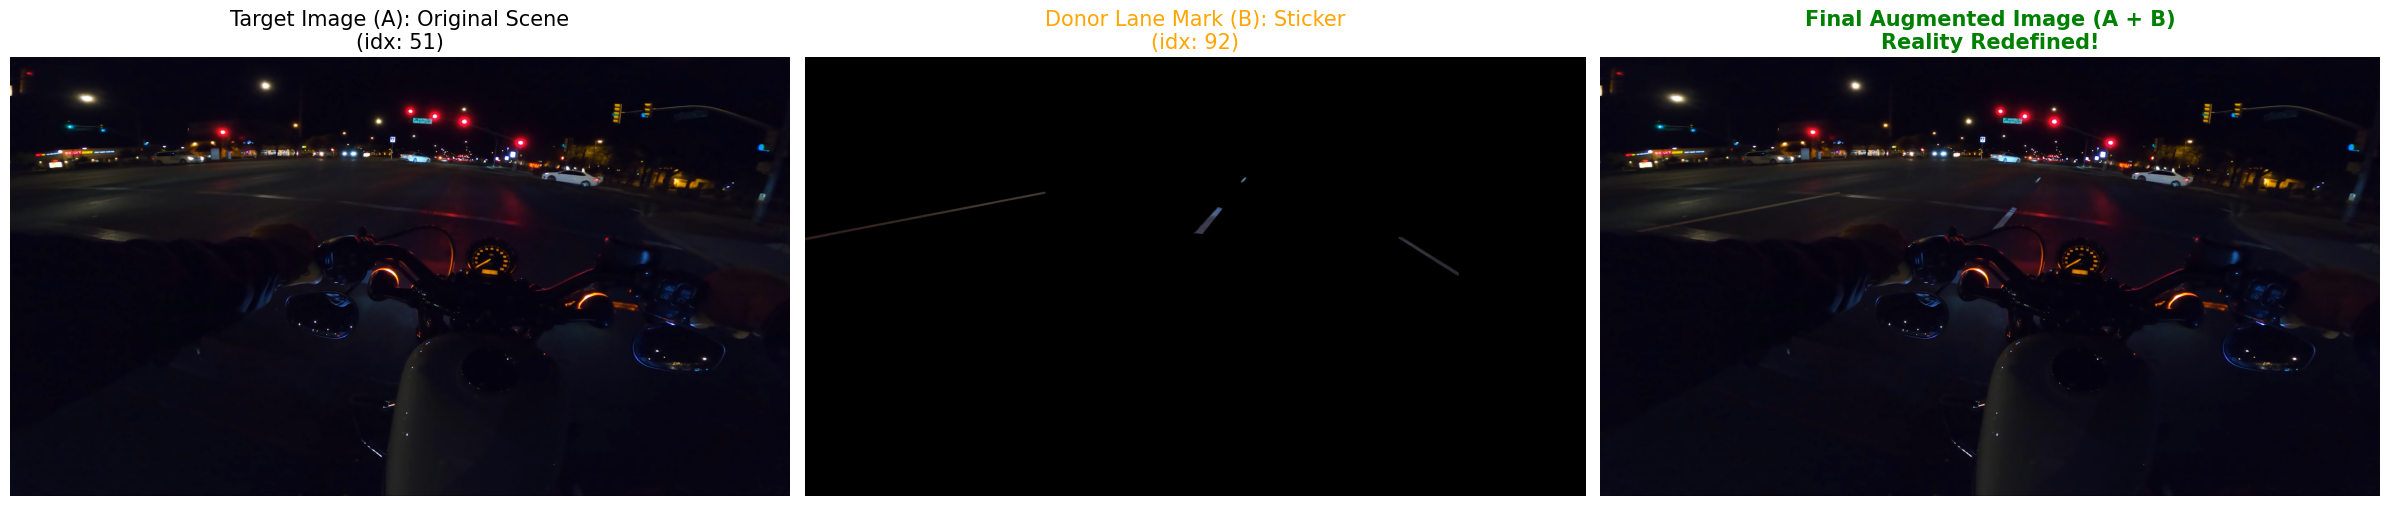

In [70]:
# ==========================================================
# 🎨 DATA AUGMENTATION MAGIC: Copy-Paste Visualization
# ==========================================================
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2

def visualize_copy_paste_magic(dataset, sample_idx=None):
    if sample_idx is None:
        sample_idx = random.randint(0, len(dataset) - 1)
    
    # [1] 원본 배경 이미지 로드 (합성 전)
    # 직접 로드하여 증강이 적용되지 않은 순정 상태를 가져옵니다.
    bg_img, bg_mask = dataset.load_image_mask(sample_idx)
    
    # [2] 기증자(Donor) 이미지 로드 (차선을 빌려올 곳)
    donor_idx = random.randint(0, len(dataset) - 1)
    donor_img, donor_mask = dataset.load_image_mask(donor_idx)
    
    # [3] 차선(Lane Mark: 3) 영역만 추출
    lane_mask = (donor_mask == 3)
    
    # [4] 합성 수행 (Copy-Paste)
    pasted_img = bg_img.copy()
    pasted_mask = bg_mask.copy()
    
    if np.any(lane_mask):
        # 🛡️ 오토바이나 라이더 영역 보호 (0: Rider, 1: My bike)
        protected_mask = np.isin(bg_mask, [0, 1])
        final_paste_mask = lane_mask & ~protected_mask
        
        pasted_img[final_paste_mask] = donor_img[final_paste_mask]
        pasted_mask[final_paste_mask] = donor_mask[final_paste_mask]
        
    # 시각화 (원본 vs 기증자 차선 vs 합성 결과)
    fig, axes = plt.subplots(1, 3, figsize=(24, 8))
    
    # 왼쪽: 원본 배경
    axes[0].imshow(bg_img)
    axes[0].set_title(f"Target Image (A): Original Scene\n(idx: {sample_idx})", fontsize=15)
    axes[0].axis('off')
    
    # 중앙: 기증자로부터 떼어온 '차선 스티커'
    sticker_view = np.zeros_like(donor_img)
    sticker_view[lane_mask] = donor_img[lane_mask]
    axes[1].imshow(sticker_view)
    axes[1].set_title(f"Donor Lane Mark (B): Sticker\n(idx: {donor_idx})", fontsize=15, color='orange')
    axes[1].axis('off')
    
    # 오른쪽: 최종 합성 결과
    axes[2].imshow(pasted_img)
    axes[2].set_title(f"Final Augmented Image (A + B)\nReality Redefined!", fontsize=15, color='green', fontweight='bold')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

# 실행! (Dataset 정의 이후 섹션에서 실행)
if 'train_dataset' in locals():
    visualize_copy_paste_magic(train_dataset)
else:
    print("⚠️ train_dataset이 아직 정의되지 않았습니다. 위쪽 셀들을 먼저 실행해주세요.")


### 📉 클래스별 분포 요약 (내림차순)

1. **Undrivable (주행 불가 영역)**: **42.9%** (압도적 1위)
   - 배경(하늘, 건물, 풀숲 등)이 이미지의 절반 가까이 차지합니다.
2. **Road (주행 가능 도로)**: **27.1%**
   - 도로 자체도 꽤 많은 영역을 차지합니다.
3. **My bike (내 오토바이)**: **15.8%**
   - 주행자 시점이라 내 오토바이가 항상 보이기 때문에 비율이 높습니다.
4. **Rider (탑승자)**: **8.1%**
   - 다른 오토바이 운전자나 내 신체가 포함된 것으로 보입니다.
5. **Moveable (이동 물체)**: **4.7%**
   - 다른 차량, 보행자 등 안전에 가장 중요한 장애물인데 비율이 매우 낮습니다.
6. **Lane Mark (차선)**: **1.4%**
   - 가장 심각한 불균형입니다. 도로 주행의 핵심인 차선이 고작 1% 남짓입니다.

In [71]:
id2label = {i: coco.loadCats(cat_id)[0]['name'] for cat_id, i in id_to_idx.items()}
label2id = {v: k for k, v in id2label.items()}

model = SegformerForSemanticSegmentation.from_pretrained(
    CFG['model_name'],
    num_labels=len(id_to_idx),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
).to(CFG['device'])

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=CFG['lr'], # Learning Rate
    weight_decay=0.05 #가중치의 관성 제어, 옵티마이저에서 0.01이라는 값은 매 학습 단계(Step)마다 현재 가중치 값을 얼마나 깎을지를 결정하는 비율입니다.
)

# ⚖️ 클래스별 가중치 설정 (Class Weights)
weights = torch.tensor([
    3.0,   # Rider: 5.0 → 3.0 (중요하지만 과하지 않게)
    1.5,   # My bike: 2.0 → 1.5 (내 오토바이는 너무 잘 맞히니 조금 더 낮춤)
    6.0,   # Moveable: 10.0 → 6.0 (절반으로 줄여서 부담 완화)
    12.0,  # Lane Mark: 20.0 → 12 (여전히 제일 강력하지만, 20배는 너무 가혹했음)
    1.0,   # Road: 1.0 (기준점 유지)
    0.8    # Undrivable: 0.5 → 0.8 (배경을 너무 무시해서 도로 경계가 무너지는 것 방지)
], dtype=torch.float).to(CFG['device'])

criterion = nn.CrossEntropyLoss(weight=weights)

scaler = GradScaler('cuda') if CFG['device'] == 'cuda' else None

Loading weights:   0%|          | 0/380 [00:00<?, ?it/s]

In [54]:
import torch
import numpy as np
import cv2
from sklearn.metrics import confusion_matrix

# [1] 기본 IoU 계산 로직 (Category-specific)
def compute_category_iou(preds, targets, num_classes):
    preds_flat = preds.flatten().cpu().numpy()
    targets_flat = targets.flatten().cpu().numpy()
    valid_mask = (targets_flat >= 0) & (targets_flat < num_classes)
    preds_flat = preds_flat[valid_mask]
    targets_flat = targets_flat[valid_mask]
    cm = confusion_matrix(targets_flat, preds_flat, labels=range(num_classes))
    intersection = np.diag(cm)
    ground_truth_set = cm.sum(axis=1)
    predicted_set = cm.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection
    iou = intersection / (union + 1e-6)
    return iou

# [2] Boundary IoU 계산 로직
def get_boundary(mask, dilation_pixels=2):
    mask = mask.astype(np.uint8)
    kernel = np.ones((3, 3), np.uint8)
    eroded = cv2.erode(mask, kernel, iterations=dilation_pixels)
    boundary = mask - eroded
    return boundary

def compute_boundary_iou(preds, targets, num_classes, dilation_pixels=2):
    preds_np = preds.cpu().numpy()
    targets_np = targets.cpu().numpy()
    b_ious = []
    for c in range(num_classes):
        class_preds = (preds_np == c)
        class_targets = (targets_np == c)
        ious_per_batch = []
        for i in range(preds_np.shape[0]):
            gt_boundary = get_boundary(class_targets[i], dilation_pixels)
            pred_boundary = get_boundary(class_preds[i], dilation_pixels)
            intersection = ((gt_boundary > 0) & (pred_boundary > 0)).sum()
            union = ((gt_boundary > 0) | (pred_boundary > 0)).sum()
            if union == 0:
                ious_per_batch.append(1.0)
            else:
                ious_per_batch.append(intersection / union)
        if not ious_per_batch:
            b_ious.append(0.0)
        else:
            b_ious.append(np.mean(ious_per_batch))
    return np.array(b_ious)

# [3] 통합 평가 함수 (Metrics Calculation)
def evaluate_metrics(preds, targets, num_classes):
    """예측값과 정답을 받아 모든 지표(Category IoU, Boundary IoU)를 한 번에 계산"""
    cat_iou = compute_category_iou(preds, targets, num_classes)
    bound_iou = compute_boundary_iou(preds, targets, num_classes)
    return cat_iou, bound_iou

# [4] 상세 리포트 출력 함수 (Report Generation)
def print_evaluation_report(avg_cat_iou, avg_bound_iou, id2label=None):
    """계산된 평균 IoU 값들을 받아 보기 좋게 출력"""
    print("\n[Validation Report]")
    print("  Category-specific IoU:")
    for i, iou in enumerate(avg_cat_iou):
        label = id2label[i] if id2label else f"Class {i}"
        print(f"    - {label}: {iou:.4f}")

    print("\n  Boundary IoU (Details):")
    for i, iou in enumerate(avg_bound_iou):
        label = id2label[i] if id2label else f"Class {i}"
        print(f"    - {label}: {iou:.4f}")

    mIoU = np.nanmean(avg_cat_iou)
    mBoU = np.nanmean(avg_bound_iou)
    print(f"\n  --> mIoU: {mIoU:.4f} | mBoU: {mBoU:.4f}\n")
    return mIoU, mBoU


In [55]:
# [공통 로직] 데이터 전송, 추론, 확대, 손실 계산
def forward_step(model, images, masks, criterion, device):
    # 데이터를 장치로 이동
    X = images.to(device)
    y = masks.to(device)

    # 1. Forward Pass (MPS 상에서 수행)
    logits = model(X).logits
    
    # [1] Label Downsampling (Grad-free path)
    y_down = nn.functional.interpolate(
        y.unsqueeze(1).float(), 
        size=logits.shape[-2:], 
        mode="nearest"
    ).squeeze(1).long().contiguous()

    # [2] 손실 계산 (MPS)
    # 💎 monkey-patch 덕분에 이제 여기서 직접 계산해도 에러가 나지 않아야 합니다.
    loss = criterion(logits, y_down)

    # 평가용 (학습 그래프와 무관)
    with torch.no_grad():
        upsampled_logits = nn.functional.interpolate(
            logits, size=y.shape[-2:], mode="bilinear", align_corners=False
        )

    return loss, upsampled_logits, y

# [학습 단계] 한 에폭 동안의 학습 집행
def train_one_epoch(model, loader, optimizer, criterion, device, scaler=None, epoch=0):
    model.train()
    train_loss_sum = 0
    pbar = tqdm(loader, desc=f"Epoch {epoch+1} [Train]")

    for images, masks in pbar:
        optimizer.zero_grad()

        # Mixed Precision 지원 (MPS에서는 종종 view 에러를 유발하므로 CUDA 전용으로 제한)
        if device == 'cuda' and scaler:
            with torch.amp.autocast('cuda'):
                loss, _, _ = forward_step(model, images, masks, criterion, device)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            # 역전파 및 가중치 업데이트
            loss, _, _ = forward_step(model, images, masks, criterion, device)
            loss.backward()
            optimizer.step()

        # 모델이 예측한 값과 정답 사이의 거리 기록
        train_loss_sum += loss.item()
        pbar.set_postfix(Loss=f"{loss.item():.4f}")

    return train_loss_sum / len(loader)

# [검증 단계] 모듈화된 평가 로직 적용
def validate(model, loader, criterion, device, num_classes=6, id2label=None):
    model.eval()
    val_loss_sum = 0

    # 지표 누적용 배열 (Total Accumulators)
    total_cat_ious = np.zeros(num_classes)
    total_bound_ious = np.zeros(num_classes)

    with torch.no_grad():
        for images, masks in loader:
            # 1. 공통 로직 실행 (Loss 계산)
            loss, logits, y = forward_step(model, images, masks, criterion, device)
            val_loss_sum += loss.item()

            # 2. 예측값 변환
            preds = torch.argmax(logits, dim=1)

            # 3. 통합 평가 모듈 호출
            cat_iou, bound_iou = evaluate_metrics(preds, y, num_classes)
            total_cat_ious += cat_iou
            total_bound_ious += bound_iou

    # 에폭 평균 계산
    avg_loss = val_loss_sum / len(loader)
    avg_cat_iou = total_cat_ious / len(loader)
    avg_bound_iou = total_bound_ious / len(loader)

    # 4. 상세 리포트 출력 모듈 호출
    mIoU, mBoU = print_evaluation_report(avg_cat_iou, avg_bound_iou, id2label)

    return avg_loss, mIoU, mBoU, avg_cat_iou, avg_bound_iou



### 평가 항목
- **mIoU** (Mean Intersection over Union): only Validation
  - **Category-specific IoU** 
  - **Boundary IoU**
- CrossEntropyLoss : train loss/ validation loss   

In [56]:
# --- 🚀 메인 학습 루프 (Auto-Save 기능 탑재) ---
print("🚀 SegFormer-B2 Training Start with Dual Auto-Save Strategy...")

wandb.init(project=CFG['project'], config=CFG)

best_miou = 0.0
best_mbou = 0.0
best_miou_epoch = 0

save_dir = "./checkpoints"
os.makedirs(save_dir, exist_ok=True)

for epoch in range(CFG['epochs']):
    # 1. 학습 실행
    avg_train_loss = train_one_epoch(model, train_loader, optimizer, criterion, CFG['device'], scaler, epoch)

    # 2. 검증 실행
    avg_val_loss, avg_val_miou, avg_val_mbou, mean_cat_ious, mean_bound_ious = validate(model, val_loader, criterion, CFG['device'], num_classes=6, id2label=id2label)


    # --- WandB 통합 로깅 (정밀 모니터링) ---
    log_dict = {
        'epoch': epoch,
        'Loss/Train': avg_train_loss,
        'Loss/Val': avg_val_loss,
        'Metrics/mIoU': avg_val_miou,
        'Metrics/mBoU': avg_val_mbou
    }

    # 클래스별 상세 IoU 기록
    for i, (cat_iou, b_iou) in enumerate(zip(mean_cat_ious, mean_bound_ious)):
        cls_name = id2label[i]
        log_dict[f'Class_IoU/{cls_name}'] = cat_iou
        log_dict[f'Class_Boundary_IoU/{cls_name}'] = b_iou

    wandb.log(log_dict)



    print(f"📝 Epoch [{epoch+1}/{CFG['epochs']}]")
    print(f"   Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    print(f"   ✨ Val mIoU: {avg_val_miou:.4f} | mBoU: {avg_val_mbou:.4f}")

    # --------------------------------------------------------------------------
    # 💾 3. 이중 자동 저장 (Dual Auto-Save)
    # --------------------------------------------------------------------------
    # [기준 1] mIoU 챔피언 (가장 똑똑한 모델)
    if avg_val_miou > best_miou:
        print(f"   🏆 New Best mIoU! ({best_miou:.4f} -> {avg_val_miou:.4f}) Saving...")
        best_miou = avg_val_miou
        best_miou_epoch = epoch + 1
        torch.save(model.state_dict(), os.path.join(save_dir, "segformer_best_miou.pth"))

    # [기준 2] mBoU 챔피언 (테두리 장인)
    if avg_val_mbou > best_mbou:
        print(f"   🎨 New Best mBoU! ({best_mbou:.4f} -> {avg_val_mbou:.4f}) Saving...")
        best_mbou = avg_val_mbou
        torch.save(model.state_dict(), os.path.join(save_dir, "segformer_best_mbou.pth"))

    # 0.5 수준: "기반은 닦았으나, 고득점 문제는 포기한 상태"
    # 0.1 수준: "실전에 투입해볼 만한 우등생"
    # 0.01 수준: "완벽, 혹은 너무 과한 공부(과적합)"
    print("-" * 50)

print(f"\n🎉 Training Complete!")
print(f"   👑 Overall Best mIoU: {best_miou:.4f} (at Epoch {best_miou_epoch})")
print(f"   🖌️ Overall Best mBoU: {best_mbou:.4f}")
# 마지막 상태도 저장
torch.save(model.state_dict(), os.path.join(save_dir, "segformer_last.pth"))

wandb.finish()



🚀 SegFormer-B2 Training Start with Dual Auto-Save Strategy...


Epoch 1 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]


[Validation Report]
  Category-specific IoU:
    - Rider: 0.6478
    - My bike: 0.7937
    - Moveable: 0.4182
    - Lane Mark: 0.1036
    - Road: 0.6099
    - Undrivable: 0.8771

  Boundary IoU (Details):
    - Rider: 0.0238
    - My bike: 0.0741
    - Moveable: 0.0368
    - Lane Mark: 0.0230
    - Road: 0.0447
    - Undrivable: 0.0363

  --> mIoU: 0.5750 | mBoU: 0.0398

📝 Epoch [1/20]
   Train Loss: 1.2890 | Val Loss: 0.7868
   ✨ Val mIoU: 0.5750 | mBoU: 0.0398
   🏆 New Best mIoU! (0.0000 -> 0.5750) Saving...
   🎨 New Best mBoU! (0.0000 -> 0.0398) Saving...
--------------------------------------------------


Epoch 2 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]


[Validation Report]
  Category-specific IoU:
    - Rider: 0.7386
    - My bike: 0.8615
    - Moveable: 0.5590
    - Lane Mark: 0.1340
    - Road: 0.7084
    - Undrivable: 0.8915

  Boundary IoU (Details):
    - Rider: 0.0566
    - My bike: 0.1159
    - Moveable: 0.0643
    - Lane Mark: 0.0243
    - Road: 0.0719
    - Undrivable: 0.0427

  --> mIoU: 0.6488 | mBoU: 0.0626

📝 Epoch [2/20]
   Train Loss: 0.7265 | Val Loss: 0.5134
   ✨ Val mIoU: 0.6488 | mBoU: 0.0626
   🏆 New Best mIoU! (0.5750 -> 0.6488) Saving...
   🎨 New Best mBoU! (0.0398 -> 0.0626) Saving...
--------------------------------------------------


Epoch 3 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]


[Validation Report]
  Category-specific IoU:
    - Rider: 0.7777
    - My bike: 0.8877
    - Moveable: 0.4789
    - Lane Mark: 0.1567
    - Road: 0.7149
    - Undrivable: 0.8993

  Boundary IoU (Details):
    - Rider: 0.0715
    - My bike: 0.1514
    - Moveable: 0.0650
    - Lane Mark: 0.0257
    - Road: 0.0874
    - Undrivable: 0.0501

  --> mIoU: 0.6525 | mBoU: 0.0752

📝 Epoch [3/20]
   Train Loss: 0.5376 | Val Loss: 0.4090
   ✨ Val mIoU: 0.6525 | mBoU: 0.0752
   🏆 New Best mIoU! (0.6488 -> 0.6525) Saving...
   🎨 New Best mBoU! (0.0626 -> 0.0752) Saving...
--------------------------------------------------


Epoch 4 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]


[Validation Report]
  Category-specific IoU:
    - Rider: 0.8047
    - My bike: 0.8964
    - Moveable: 0.5175
    - Lane Mark: 0.1418
    - Road: 0.7385
    - Undrivable: 0.8875

  Boundary IoU (Details):
    - Rider: 0.0832
    - My bike: 0.1709
    - Moveable: 0.0374
    - Lane Mark: 0.0213
    - Road: 0.1020
    - Undrivable: 0.0567

  --> mIoU: 0.6644 | mBoU: 0.0786

📝 Epoch [4/20]
   Train Loss: 0.4583 | Val Loss: 0.4006
   ✨ Val mIoU: 0.6644 | mBoU: 0.0786
   🏆 New Best mIoU! (0.6525 -> 0.6644) Saving...
   🎨 New Best mBoU! (0.0752 -> 0.0786) Saving...
--------------------------------------------------


Epoch 5 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]


[Validation Report]
  Category-specific IoU:
    - Rider: 0.8086
    - My bike: 0.8979
    - Moveable: 0.5943
    - Lane Mark: 0.2117
    - Road: 0.7811
    - Undrivable: 0.9272

  Boundary IoU (Details):
    - Rider: 0.0903
    - My bike: 0.1647
    - Moveable: 0.1018
    - Lane Mark: 0.0382
    - Road: 0.1079
    - Undrivable: 0.0666

  --> mIoU: 0.7034 | mBoU: 0.0949

📝 Epoch [5/20]
   Train Loss: 0.3893 | Val Loss: 0.3388
   ✨ Val mIoU: 0.7034 | mBoU: 0.0949
   🏆 New Best mIoU! (0.6644 -> 0.7034) Saving...
   🎨 New Best mBoU! (0.0786 -> 0.0949) Saving...
--------------------------------------------------


Epoch 6 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]


[Validation Report]
  Category-specific IoU:
    - Rider: 0.6636
    - My bike: 0.9030
    - Moveable: 0.6153
    - Lane Mark: 0.2300
    - Road: 0.7914
    - Undrivable: 0.8766

  Boundary IoU (Details):
    - Rider: 0.0884
    - My bike: 0.1838
    - Moveable: 0.0594
    - Lane Mark: 0.0519
    - Road: 0.1246
    - Undrivable: 0.0674

  --> mIoU: 0.6800 | mBoU: 0.0959

📝 Epoch [6/20]
   Train Loss: 0.3818 | Val Loss: 0.3401
   ✨ Val mIoU: 0.6800 | mBoU: 0.0959
   🎨 New Best mBoU! (0.0949 -> 0.0959) Saving...
--------------------------------------------------


Epoch 7 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]


[Validation Report]
  Category-specific IoU:
    - Rider: 0.7747
    - My bike: 0.9122
    - Moveable: 0.6460
    - Lane Mark: 0.2383
    - Road: 0.8090
    - Undrivable: 0.9126

  Boundary IoU (Details):
    - Rider: 0.1070
    - My bike: 0.1967
    - Moveable: 0.0951
    - Lane Mark: 0.0633
    - Road: 0.1450
    - Undrivable: 0.0789

  --> mIoU: 0.7155 | mBoU: 0.1143

📝 Epoch [7/20]
   Train Loss: 0.3451 | Val Loss: 0.3352
   ✨ Val mIoU: 0.7155 | mBoU: 0.1143
   🏆 New Best mIoU! (0.7034 -> 0.7155) Saving...
   🎨 New Best mBoU! (0.0959 -> 0.1143) Saving...
--------------------------------------------------


Epoch 8 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]


[Validation Report]
  Category-specific IoU:
    - Rider: 0.8035
    - My bike: 0.9158
    - Moveable: 0.6279
    - Lane Mark: 0.2137
    - Road: 0.7989
    - Undrivable: 0.9284

  Boundary IoU (Details):
    - Rider: 0.1109
    - My bike: 0.2038
    - Moveable: 0.1082
    - Lane Mark: 0.0493
    - Road: 0.1349
    - Undrivable: 0.0921

  --> mIoU: 0.7147 | mBoU: 0.1165

📝 Epoch [8/20]
   Train Loss: 0.3232 | Val Loss: 0.2998
   ✨ Val mIoU: 0.7147 | mBoU: 0.1165
   🎨 New Best mBoU! (0.1143 -> 0.1165) Saving...
--------------------------------------------------


Epoch 9 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]


[Validation Report]
  Category-specific IoU:
    - Rider: 0.8120
    - My bike: 0.9070
    - Moveable: 0.6362
    - Lane Mark: 0.2070
    - Road: 0.7731
    - Undrivable: 0.9281

  Boundary IoU (Details):
    - Rider: 0.1035
    - My bike: 0.1865
    - Moveable: 0.0766
    - Lane Mark: 0.0448
    - Road: 0.1196
    - Undrivable: 0.0854

  --> mIoU: 0.7106 | mBoU: 0.1027

📝 Epoch [9/20]
   Train Loss: 0.3072 | Val Loss: 0.2744
   ✨ Val mIoU: 0.7106 | mBoU: 0.1027
--------------------------------------------------


Epoch 10 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]


[Validation Report]
  Category-specific IoU:
    - Rider: 0.8191
    - My bike: 0.9132
    - Moveable: 0.6219
    - Lane Mark: 0.2303
    - Road: 0.7911
    - Undrivable: 0.9366

  Boundary IoU (Details):
    - Rider: 0.1031
    - My bike: 0.2026
    - Moveable: 0.0544
    - Lane Mark: 0.0558
    - Road: 0.1353
    - Undrivable: 0.0945

  --> mIoU: 0.7187 | mBoU: 0.1076

📝 Epoch [10/20]
   Train Loss: 0.2836 | Val Loss: 0.2636
   ✨ Val mIoU: 0.7187 | mBoU: 0.1076
   🏆 New Best mIoU! (0.7155 -> 0.7187) Saving...
--------------------------------------------------


Epoch 11 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]


[Validation Report]
  Category-specific IoU:
    - Rider: 0.8192
    - My bike: 0.9132
    - Moveable: 0.6362
    - Lane Mark: 0.2781
    - Road: 0.8334
    - Undrivable: 0.9422

  Boundary IoU (Details):
    - Rider: 0.1177
    - My bike: 0.2007
    - Moveable: 0.0969
    - Lane Mark: 0.0908
    - Road: 0.1635
    - Undrivable: 0.1073

  --> mIoU: 0.7371 | mBoU: 0.1295

📝 Epoch [11/20]
   Train Loss: 0.2974 | Val Loss: 0.2760
   ✨ Val mIoU: 0.7371 | mBoU: 0.1295
   🏆 New Best mIoU! (0.7187 -> 0.7371) Saving...
   🎨 New Best mBoU! (0.1165 -> 0.1295) Saving...
--------------------------------------------------


Epoch 12 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]


[Validation Report]
  Category-specific IoU:
    - Rider: 0.8241
    - My bike: 0.9089
    - Moveable: 0.6735
    - Lane Mark: 0.2845
    - Road: 0.8280
    - Undrivable: 0.9454

  Boundary IoU (Details):
    - Rider: 0.1165
    - My bike: 0.2025
    - Moveable: 0.1146
    - Lane Mark: 0.1021
    - Road: 0.1637
    - Undrivable: 0.1105

  --> mIoU: 0.7441 | mBoU: 0.1350

📝 Epoch [12/20]
   Train Loss: 0.2779 | Val Loss: 0.2717
   ✨ Val mIoU: 0.7441 | mBoU: 0.1350
   🏆 New Best mIoU! (0.7371 -> 0.7441) Saving...
   🎨 New Best mBoU! (0.1295 -> 0.1350) Saving...
--------------------------------------------------


Epoch 13 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]


[Validation Report]
  Category-specific IoU:
    - Rider: 0.8269
    - My bike: 0.9152
    - Moveable: 0.6550
    - Lane Mark: 0.2905
    - Road: 0.8308
    - Undrivable: 0.9445

  Boundary IoU (Details):
    - Rider: 0.1239
    - My bike: 0.2108
    - Moveable: 0.1171
    - Lane Mark: 0.0960
    - Road: 0.1676
    - Undrivable: 0.1131

  --> mIoU: 0.7438 | mBoU: 0.1381

📝 Epoch [13/20]
   Train Loss: 0.2554 | Val Loss: 0.2499
   ✨ Val mIoU: 0.7438 | mBoU: 0.1381
   🎨 New Best mBoU! (0.1350 -> 0.1381) Saving...
--------------------------------------------------


Epoch 14 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]


[Validation Report]
  Category-specific IoU:
    - Rider: 0.8274
    - My bike: 0.9191
    - Moveable: 0.6502
    - Lane Mark: 0.3049
    - Road: 0.8393
    - Undrivable: 0.9356

  Boundary IoU (Details):
    - Rider: 0.1294
    - My bike: 0.2207
    - Moveable: 0.1144
    - Lane Mark: 0.1155
    - Road: 0.1778
    - Undrivable: 0.1113

  --> mIoU: 0.7461 | mBoU: 0.1449

📝 Epoch [14/20]
   Train Loss: 0.2729 | Val Loss: 0.2506
   ✨ Val mIoU: 0.7461 | mBoU: 0.1449
   🏆 New Best mIoU! (0.7441 -> 0.7461) Saving...
   🎨 New Best mBoU! (0.1381 -> 0.1449) Saving...
--------------------------------------------------


Epoch 15 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]


[Validation Report]
  Category-specific IoU:
    - Rider: 0.8449
    - My bike: 0.9219
    - Moveable: 0.6791
    - Lane Mark: 0.2714
    - Road: 0.8301
    - Undrivable: 0.9364

  Boundary IoU (Details):
    - Rider: 0.1319
    - My bike: 0.2220
    - Moveable: 0.1163
    - Lane Mark: 0.0990
    - Road: 0.1715
    - Undrivable: 0.1051

  --> mIoU: 0.7473 | mBoU: 0.1410

📝 Epoch [15/20]
   Train Loss: 0.2626 | Val Loss: 0.2459
   ✨ Val mIoU: 0.7473 | mBoU: 0.1410
   🏆 New Best mIoU! (0.7461 -> 0.7473) Saving...
--------------------------------------------------


Epoch 16 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]


[Validation Report]
  Category-specific IoU:
    - Rider: 0.8214
    - My bike: 0.9203
    - Moveable: 0.6689
    - Lane Mark: 0.2921
    - Road: 0.8362
    - Undrivable: 0.9395

  Boundary IoU (Details):
    - Rider: 0.1367
    - My bike: 0.2164
    - Moveable: 0.1349
    - Lane Mark: 0.1056
    - Road: 0.1782
    - Undrivable: 0.1167

  --> mIoU: 0.7464 | mBoU: 0.1481

📝 Epoch [16/20]
   Train Loss: 0.2373 | Val Loss: 0.2438
   ✨ Val mIoU: 0.7464 | mBoU: 0.1481
   🎨 New Best mBoU! (0.1449 -> 0.1481) Saving...
--------------------------------------------------


Epoch 17 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]


[Validation Report]
  Category-specific IoU:
    - Rider: 0.8409
    - My bike: 0.9252
    - Moveable: 0.6639
    - Lane Mark: 0.3160
    - Road: 0.8396
    - Undrivable: 0.9429

  Boundary IoU (Details):
    - Rider: 0.1440
    - My bike: 0.2308
    - Moveable: 0.1263
    - Lane Mark: 0.1261
    - Road: 0.1897
    - Undrivable: 0.1166

  --> mIoU: 0.7547 | mBoU: 0.1556

📝 Epoch [17/20]
   Train Loss: 0.2369 | Val Loss: 0.2514
   ✨ Val mIoU: 0.7547 | mBoU: 0.1556
   🏆 New Best mIoU! (0.7473 -> 0.7547) Saving...
   🎨 New Best mBoU! (0.1481 -> 0.1556) Saving...
--------------------------------------------------


Epoch 18 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]


[Validation Report]
  Category-specific IoU:
    - Rider: 0.8267
    - My bike: 0.9271
    - Moveable: 0.6659
    - Lane Mark: 0.3412
    - Road: 0.8449
    - Undrivable: 0.9488

  Boundary IoU (Details):
    - Rider: 0.1333
    - My bike: 0.2313
    - Moveable: 0.1205
    - Lane Mark: 0.1380
    - Road: 0.1899
    - Undrivable: 0.1183

  --> mIoU: 0.7591 | mBoU: 0.1552

📝 Epoch [18/20]
   Train Loss: 0.2362 | Val Loss: 0.2561
   ✨ Val mIoU: 0.7591 | mBoU: 0.1552
   🏆 New Best mIoU! (0.7547 -> 0.7591) Saving...
--------------------------------------------------


Epoch 19 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]


[Validation Report]
  Category-specific IoU:
    - Rider: 0.8357
    - My bike: 0.9297
    - Moveable: 0.6517
    - Lane Mark: 0.3132
    - Road: 0.8388
    - Undrivable: 0.9312

  Boundary IoU (Details):
    - Rider: 0.1380
    - My bike: 0.2384
    - Moveable: 0.0655
    - Lane Mark: 0.1301
    - Road: 0.1911
    - Undrivable: 0.1015

  --> mIoU: 0.7501 | mBoU: 0.1441

📝 Epoch [19/20]
   Train Loss: 0.2371 | Val Loss: 0.2433
   ✨ Val mIoU: 0.7501 | mBoU: 0.1441
--------------------------------------------------


Epoch 20 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]


[Validation Report]
  Category-specific IoU:
    - Rider: 0.8392
    - My bike: 0.9264
    - Moveable: 0.6294
    - Lane Mark: 0.3294
    - Road: 0.8417
    - Undrivable: 0.9403

  Boundary IoU (Details):
    - Rider: 0.1421
    - My bike: 0.2402
    - Moveable: 0.1137
    - Lane Mark: 0.1366
    - Road: 0.1972
    - Undrivable: 0.1166

  --> mIoU: 0.7511 | mBoU: 0.1577

📝 Epoch [20/20]
   Train Loss: 0.2203 | Val Loss: 0.2579
   ✨ Val mIoU: 0.7511 | mBoU: 0.1577
   🎨 New Best mBoU! (0.1556 -> 0.1577) Saving...
--------------------------------------------------

🎉 Training Complete!
   👑 Overall Best mIoU: 0.7591 (at Epoch 18)
   🖌️ Overall Best mBoU: 0.1577


## 🚦 Grad-CAM: 모델 의사결정 근거 시각화

**1. 분석 대상:** `segformer_best_miou.pth` (최고 성능 가중치 로드)
**2. 선정 이유:** **mIoU**가 가장 높은 모델의 '판단 논리'를 정성적으로 검증하기 위함

**3. 기술적 요점:**
* **Target:** Encoder Stage 4 MLP (최종 특징 추출 단계)
* **Method:** Transformer 시퀀스 데이터를 2D 피처맵($12 \times 21$)으로 복원 시각화
* **Layout:** 원본 대비 클래스별 히트맵 1행 2열 배치 (무작위 샘플링)



**💡 요약:** "가장 똑똑한 모델(Best mIoU)이 밤길 객체를 정확한 근거로 식별하는지 시각적으로 증명합니다."

✅ Loaded checkpoint: ./checkpoints/segformer_best_miou.pth


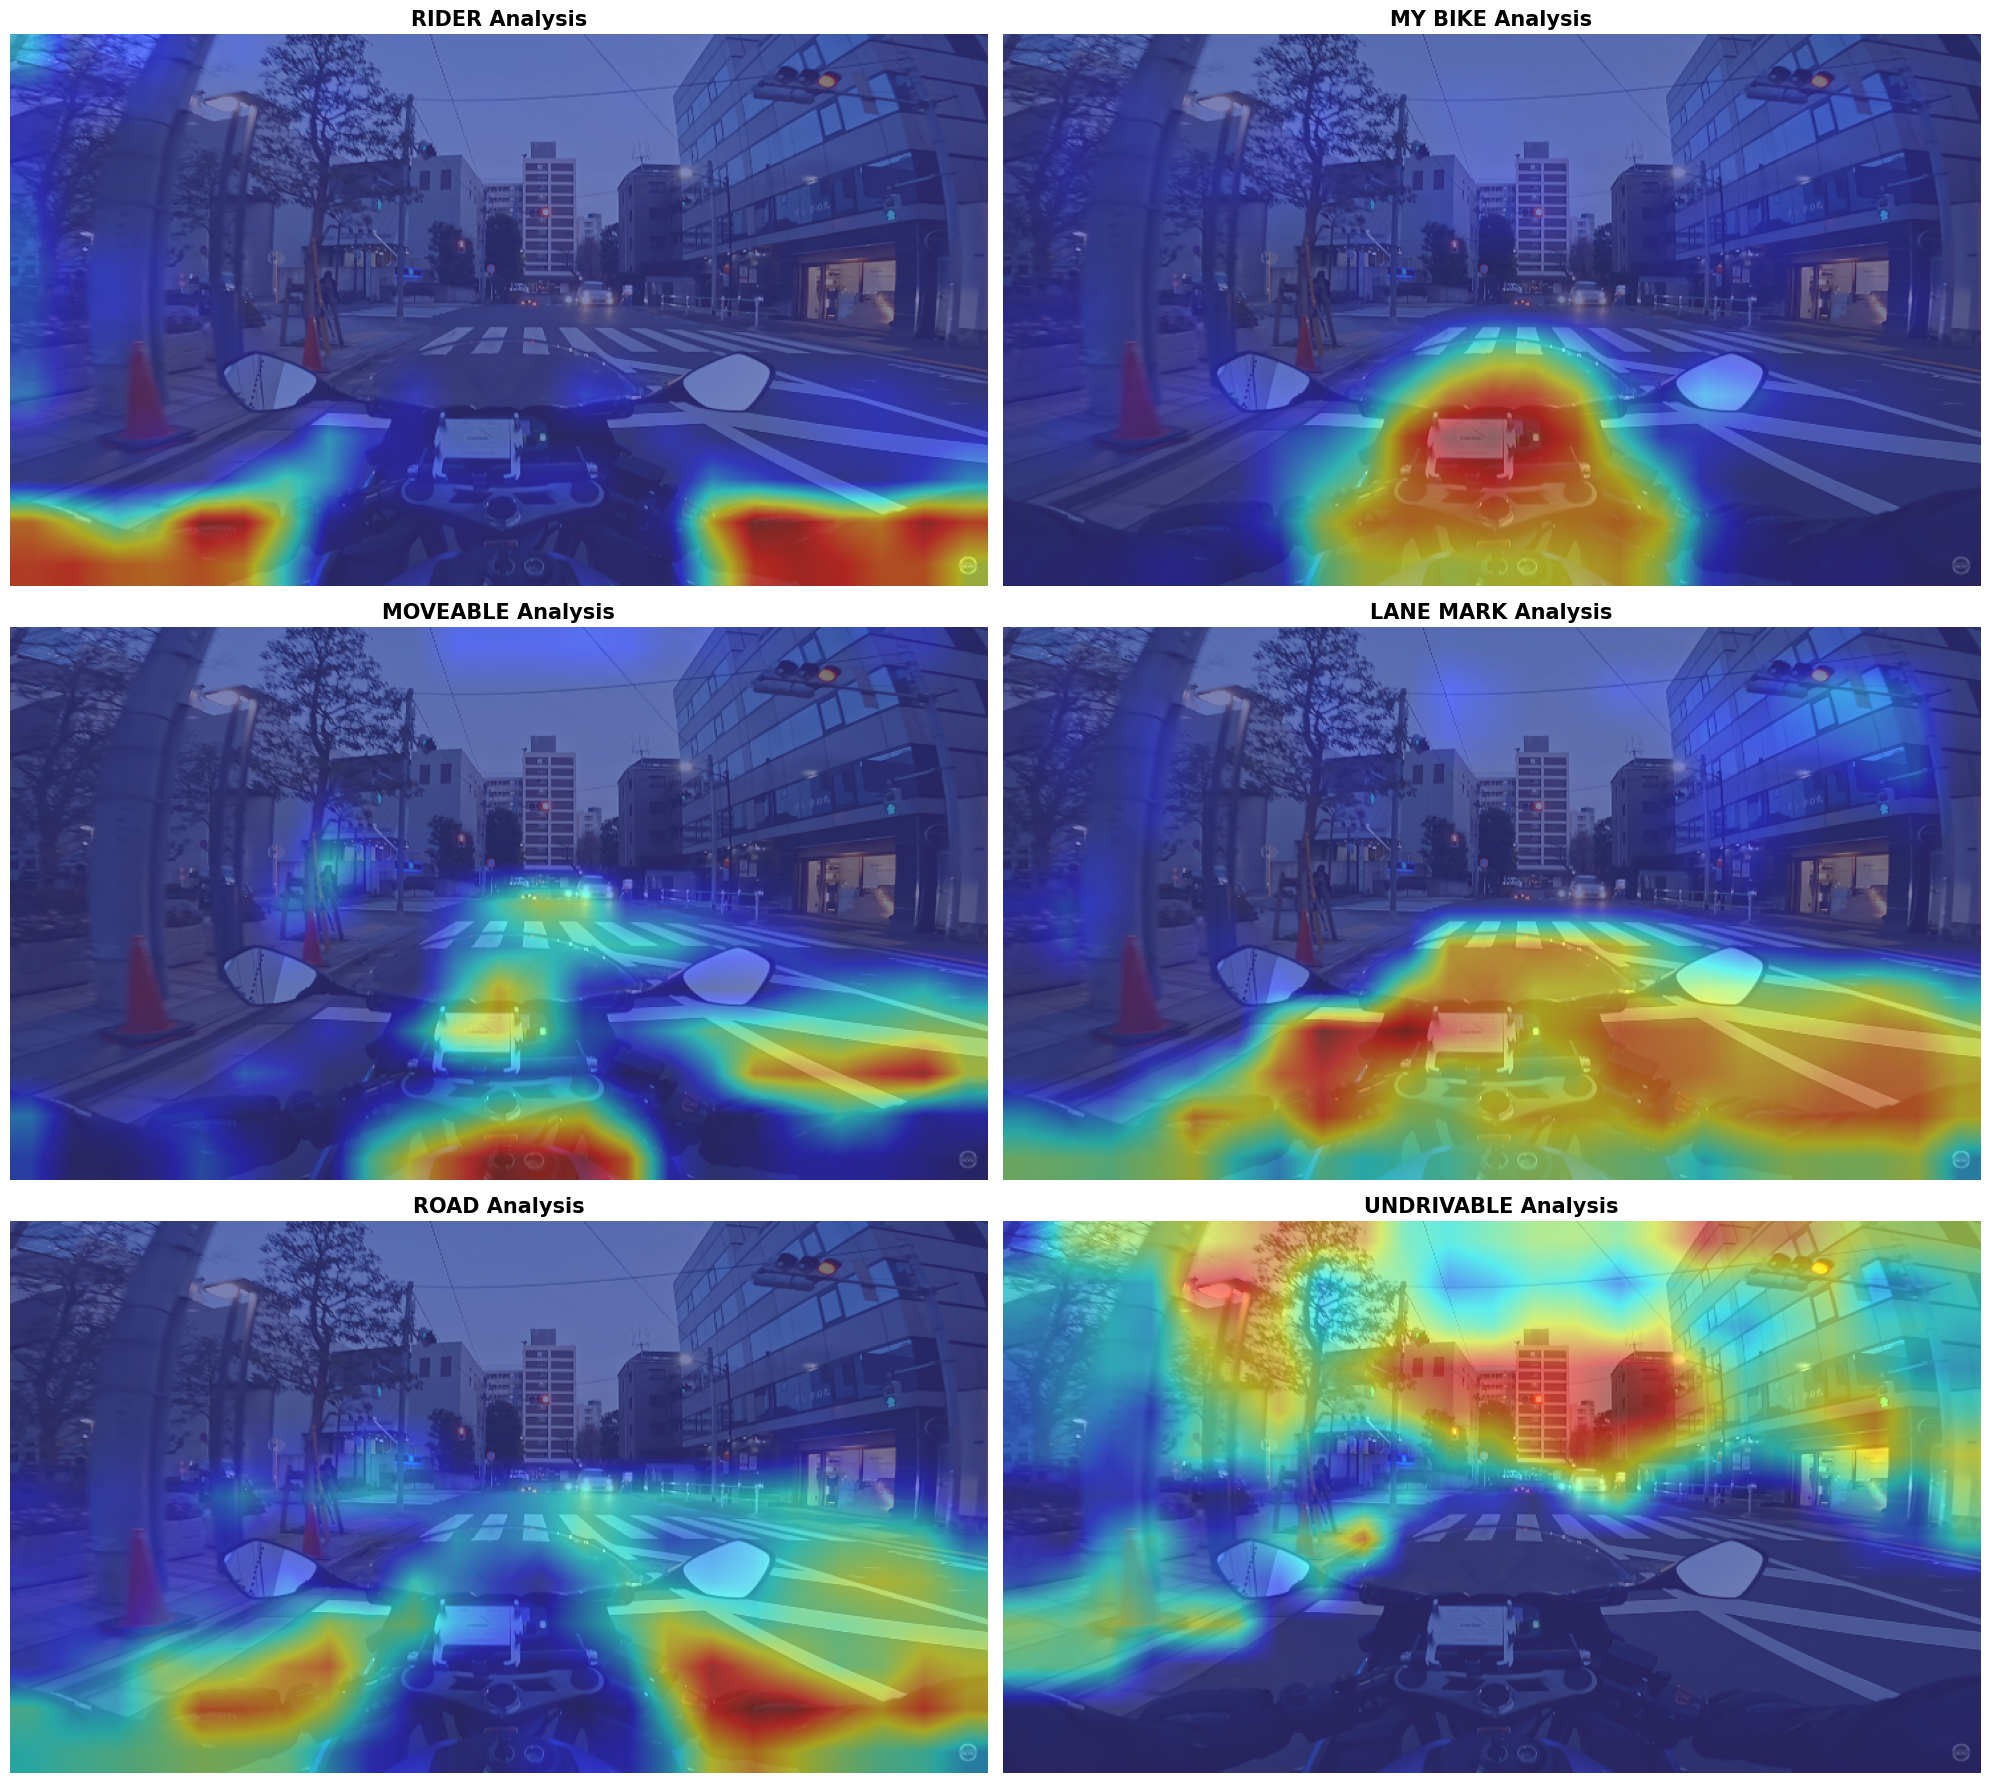

In [73]:
# !pip install grad-cam
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import SemanticSegmentationTarget

# -------------------------------------------------------------------------
# 1. 모델 및 장치 설정
# -------------------------------------------------------------------------
device = CFG['device']
checkpoint_path = "./checkpoints/segformer_best_miou.pth"

# 모델 로드
if 'model' in locals():
    if os.path.exists(checkpoint_path):
        try:
            model.load_state_dict(torch.load(checkpoint_path, map_location=device))
            print(f"✅ Loaded checkpoint: {checkpoint_path}")
        except: 
            print("⚠️ Checkpoint exists but couldn't load state_dict. Proceeding with current memory weights.")

class SegformerModelWrapper(nn.Module):
    def __init__(self, model):
        super(SegformerModelWrapper, self).__init__()
        self.model = model
    def forward(self, x):
        return self.model(x).logits

# 💡 [CORE FIX] 텐서 크기를 보고 스스로 해상도를 결정하는 지능형 함수
def segformer_reshape_transform(tensor):
    # tensor shape: [1, Tokens, Channels] (e.g., [1, 299, 512])
    batch, tokens, channels = tensor.shape
    
    # 32의 배수 해상도 가정 (SegFormer Stage 4는 1/32)
    # 현재 이미지 사이즈에서 비율을 가져옴
    h_orig, w_orig = CFG['img_size']
    aspect_ratio = w_orig / h_orig
    
    # tokens = h_feat * w_feat / aspect_ratio = w_feat / h_feat
    # h_feat = sqrt(tokens / aspect_ratio)
    h_feat = int(round(np.sqrt(tokens / aspect_ratio)))
    w_feat = tokens // h_feat
    
    # 검증: 소수점 오차로 안 맞을 경우 보정
    if h_feat * w_feat != tokens:
        # 416x736 -> (416/32=13, 736/32=23) -> 13*23=299
        if tokens == 299: h_feat, w_feat = 13, 23
        # 384x672 -> (384/32=12, 672/32=21) -> 12*21=252
        elif tokens == 252: h_feat, w_feat = 12, 21
    
    # Reshape and Transpose to [Batch, Channels, H, W]
    result = tensor.reshape(batch, h_feat, w_feat, channels)
    result = result.transpose(2, 3).transpose(1, 2)
    return result

wrapped_model = SegformerModelWrapper(model).to(device)
wrapped_model.eval()

# Stage 4 MLP 타겟
target_layers = [wrapped_model.model.segformer.encoder.block[3][1].mlp]
cam = GradCAM(model=wrapped_model, 
              target_layers=target_layers, 
              reshape_transform=segformer_reshape_transform)

# -------------------------------------------------------------------------
# 2. 분석 및 시각화
# -------------------------------------------------------------------------
if 'val_dataset' in locals():
    # 데이터 선택 및 준비
    random_idx = random.randint(0, len(val_dataset) - 1)
    image_tensor, _ = val_dataset[random_idx]
    input_tensor = image_tensor.unsqueeze(0).to(device)
    input_tensor.requires_grad = True

    # 배경 이미지 (De-normalization)
    rgb_img = input_tensor[0].detach().cpu().permute(1, 2, 0).numpy()
    mean, std = np.array([0.485, 0.456, 0.406]), np.array([0.229, 0.224, 0.225])
    rgb_img = np.clip(rgb_img * std + mean, 0, 1).astype(np.float32)

    # 시각화 박스 설정
    num_classes = 6
    fig, axes = plt.subplots(3, 2, figsize=(20, 18))
    axes = axes.flatten()

    # CAM 마스크 크기 (1/4 해상도)
    output_h, output_w = input_tensor.shape[2] // 4, input_tensor.shape[3] // 4
    mask_float = np.ones((output_h, output_w), dtype=np.float32)

    for i in range(num_classes):
        try:
            targets = [SemanticSegmentationTarget(category=i, mask=mask_float)]
            grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]
            visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
            axes[i].imshow(visualization)
            axes[i].set_title(f"{id2label[i].upper()} Analysis", fontsize=15, fontweight='bold')
        except Exception as e:
            axes[i].text(0.5, 0.5, f"CAM Error: {e}", ha='center', va='center')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("⚠️ val_dataset is not defined.")


## 🚀 Enhanced Evaluation & Profiling

### 🛠️ 주요 평가 항목
- **실시간성 및 하드웨어 지표**
  - **Model Parameters**
  - **MACs** Multiply-Accumulate Operations
    - y = wx + b 에서 wx + b를 1MAC 이라고 한다.
  - **GFLOPs** Giga Floating Point Operations
    -  모델을 한 번 실행(Forward Pass)할 때 필요한 총 부동 소수점 연산량
    - 보통 1MAC = 2FLOPs
  - **Average Inference Latency**
  - **Frames Per Second (FPS)**
- **Safety-critical Metrics**

In [74]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


class SafetyEvalMetrics:
    def __init__(self, num_classes, class_names):
        self.num_classes = num_classes
        self.class_names = class_names
        self.confusion_matrix = np.zeros((num_classes, num_classes))

    def update(self, preds, gts):
        """
        한 배치(Batch) 또는 한 프레임의 결과를 누적합니다.
        preds, gts: [Batch, H, W] 형태의 Tensor 또는 Numpy
        """
        preds = preds.flatten()
        gts = gts.flatten()

        # 유효하지 않은 타겟 값 제외 (예: 패딩 또는 ignore_index가 포함된 경우)
        valid_mask = (gts >= 0) & (gts < self.num_classes)
        preds = preds[valid_mask]
        gts = gts[valid_mask]

        # sklearn의 confusion_matrix를 사용하여 매트릭스 업데이트
        # labels 인자를 명시적으로 제공하여 모든 클래스가 포함되도록 보장
        new_cm = confusion_matrix(gts, preds, labels=range(self.num_classes))
        self.confusion_matrix += new_cm

    def plot_confusion_matrix(self, normalize=True):
        """
        혼동 행렬 시각화
        """
        cm = self.confusion_matrix
        if normalize:
            # 행(Actual) 기준 정규화: 해당 클래스가 실제 무엇으로 예측되었는지 비율 확인
            # 0으로 나누는 오류 방지를 위해 1e-9 추가
            cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-9)

        plt.figure(figsize=(8, 5))
        sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d",
                    cmap="Blues", xticklabels=self.class_names, yticklabels=self.class_names)

        plt.title('Road Scene Segmentation: Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('Ground Truth Label')
        plt.show()

    def analyze_safety_risks(self):
        """
        치명적 오분류(Safety-Critical) 집중 분석
        """
        cm_norm = self.confusion_matrix.astype('float') / (self.confusion_matrix.sum(axis=1)[:, np.newaxis] + 1e-9)

        print("\n=== [Safety-Critical Analysis] ===")

        try:
            rider_idx = self.class_names.index('Rider')
            mybike_idx = self.class_names.index('My bike')
            moveable_idx = self.class_names.index('Moveable')
            lanemark_idx = self.class_names.index('Lane Mark')
            road_idx = self.class_names.index('Road')
            undrivable_idx = self.class_names.index('Undrivable')

            print("--- 고위험 ---")
            # Case 1: Undrivable (주행 불가 영역)이 Road (주행 가능 도로)로 오분류된 경우
            # 실제 장애물이나 위험 지역을 도로로 인식하여 충돌 위험이 매우 높음.
            undrivable_as_road = cm_norm[undrivable_idx, road_idx]
            print(f"1. 즉각적인 충돌 위험 - 'Undrivable' 영역의 {undrivable_as_road:.2%}가 'Road'로 오분류 됨.")

            # Case 2: Moveable (이동 물체)이 Undrivable (주행 불가 영역)로 오분류된 경우
            # 다른 차량이나 보행자 등 중요한 이동 장애물을 감지하지 못하고 통행 불가 영역으로 표시했음을 의미.
            missed_moveable_as_undrivable = cm_norm[moveable_idx, undrivable_idx]
            print(f"2. 이동 물체 충돌 위험 - 'Moveable' 객체의 {missed_moveable_as_undrivable:.2%}가 'Undrivable'로 오분류 됨.")

            # Case 3: Moveable (이동 물체)이 Road (주행 가능 도로)로 오분류된 경우
            # 다른 차량이나 보행자 등 중요한 이동 장애물을 감지하지 못하고 안전한 주행 가능 영역으로 표시했음을 의미.
            missed_moveable_as_road = cm_norm[moveable_idx, road_idx]
            print(f"3. 이동 물체 충돌 위험 - 'Moveable' 객체의 {missed_moveable_as_road:.2%}가 'Road'로 오분류 됨.")

            # Case 4: Rider (탑승자)가 Undrivable (주행 불가 영역)로 오분류된 경우
            # 자율주행 시스템이 탑승자(자신)를 장애물로 인식하여 불필요한 회피 기동이나 정지를 유발할 수 있음.
            rider_as_undrivable = cm_norm[rider_idx, undrivable_idx]
            print(f"4. 시스템 오작동 유발 - 'Rider' 객체의 {rider_as_undrivable:.2%}가 'Undrivable'로 오분류 됨.")

            print("\n--- 중위험 ---")
            # Case 5: Road (주행 가능 도로)가 Undrivable (주행 불가 영역)로 오분류된 경우
            # 주행 가능한 도로를 통행 불가능하다고 간주하여 잘못된 경로 계획이나 불필요한 제동으로 이어질 수 있음.
            road_to_undrivable = cm_norm[road_idx, undrivable_idx]
            print(f"5. 경로 계획 오류 - 'Road' 영역의 {road_to_undrivable:.2%}가 'Undrivable'로 오분류 됨.")

            # Case 6: Lane Mark (차선)가 Road (주행 가능 도로)로 오분류된 경우
            # 차선이 도로의 일부로 인식되어 차선 유지 보조 시스템의 오작동을 유발하거나 차선 이탈을 방지하지 못할 수 있음.
            lanemark_as_road = cm_norm[lanemark_idx, road_idx]
            print(f"6. 차선 유지 보조 오류 - 'Lane Mark' 영역의 {lanemark_as_road:.2%}가 'Road'로 오분류 됨.")

            print("\n--- 낮은-중간 위험 ---")
            # Case 7: Rider (탑승자)가 My bike (내 오토바이)로 오분류된 경우
            # 시스템의 자기 인식에 혼란을 주지만, 직접적인 충돌 위험은 낮음. 정밀한 자율 주행에는 영향.
            rider_as_mybike = cm_norm[rider_idx, mybike_idx]
            print(f"7. 자기 인식 오류 - 'Rider' 객체의 {rider_as_mybike:.2%}가 'My bike'로 오분류 됨.")

        except ValueError as e:
            print(f"오류: 데이터셋의 클래스 이름을 확인하세요: {e}")


In [75]:
import time
from thop import profile

def profile_model(model, img_size, device):
    print(f"🚀 Starting Model Profiling for: {model.__class__.__name__}...")

    # 모델을 평가 모드로 설정
    model.eval()

    # 2. 모델을 위한 더미 입력 텐서 생성
    dummy_input = torch.randn(1, 3, img_size[0], img_size[1]).to(device)

    # 3. 더미 입력을 사용하여 모델의 MACs 및 매개변수(params)를 계산하기 위해 thop.profile 사용. verbose=False로 설정.
    macs, params = profile(model, inputs=(dummy_input,), verbose=False)

    # 4. 계산된 MACs를 1e9로 나누어 GFLOPs로 변환.
    gflops = (macs * 2) / 1e9

    print(f"  Model Parameters (M): {params / 1e6:.2f}")
    print(f"  MACs (G): {macs / 1e9:.2f}")
    print(f"  GFLOPs: {gflops:.2f}")

    # 5. 지연 시간 및 FPS 측정을 위한 변수 초기화.
    num_warmup_runs = 10
    num_inference_runs = 100
    total_latency = 0.0

    # 6. 워밍업 실행 수행
    # print(f"  Performing {num_warmup_runs} warm-up runs...")
    with torch.no_grad():
        for _ in range(num_warmup_runs):
            _ = model(dummy_input)

    # 7. 추론 지연 시간 측정
    # print(f"  Measuring latency over {num_inference_runs} inference runs...")
    with torch.no_grad():
        for _ in range(num_inference_runs):
            start_time = time.perf_counter()
            _ = model(dummy_input)
            end_time = time.perf_counter()
            total_latency += (end_time - start_time)

    # 8. 평균 지연 시간(ms) 계산
    average_latency_ms = (total_latency / num_inference_runs) * 1000

    # 9. FPS 계산
    fps = 1000 / average_latency_ms

    print(f"  Average Inference Latency: {average_latency_ms:.2f} ms")
    print(f"  Frames Per Second (FPS): {fps:.2f}")

def run_safety_evaluation(model, model_name, loader, device, num_classes, id2label):
    print(f"🚀 Starting Safety Evaluation for: {model_name}...")
    
    # 1. 클래스 이름 준비 (ID 순서대로 정렬)
    class_names = [name for i, name in sorted(id2label.items())]
    
    # 2. 전용 평가기 인스턴스 생성
    evaluator = SafetyEvalMetrics(num_classes=num_classes, class_names=class_names)
    
    # 3. 모델을 평가 모드로 설정
    model.eval()
    
    # 4. 루프를 돌며 예측 및 행렬 업데이트
    with torch.no_grad():
        for images, masks in tqdm(loader, desc=f"Evaluating {model_name}"):
            X = images.to(device).contiguous()
            y = masks.to(device).contiguous()

            # 모델 추론
            outputs = model(X).logits
            
            # 마스크 크기에 맞게 업샘플링
            upsampled_logits = nn.functional.interpolate(
                outputs,
                size=y.shape[-2:],
                mode="bilinear",
                align_corners=False
            )

            preds = upsampled_logits.argmax(dim=1)
            
            # 결과 누적
            evaluator.update(preds.cpu().numpy(), y.cpu().numpy())

    # 5. 결과 시각화 및 리스크 분석 출력
    print(f"\n📊 Confusion Matrix: {model_name}")
    evaluator.plot_confusion_matrix(normalize=True)
    
    print(f"\n⚠️ Safety Risk Analysis: {model_name}")
    evaluator.analyze_safety_risks()


Loading weights:   0%|          | 0/380 [00:00<?, ?it/s]

SegformerForSemanticSegmentation LOAD REPORT from: nvidia/segformer-b2-finetuned-cityscapes-1024-1024
Key                           | Status   |                                                                                                    
------------------------------+----------+----------------------------------------------------------------------------------------------------
decode_head.classifier.weight | MISMATCH | Reinit due to size mismatch - ckpt: torch.Size([19, 768, 1, 1]) vs model:torch.Size([6, 768, 1, 1])
decode_head.classifier.bias   | MISMATCH | Reinit due to size mismatch - ckpt: torch.Size([19]) vs model:torch.Size([6])                      

Notes:
- MISMATCH	:ckpt weights were loaded, but they did not match the original empty weight shapes.


Loading weights:   0%|          | 0/380 [00:00<?, ?it/s]

SegformerForSemanticSegmentation LOAD REPORT from: nvidia/segformer-b2-finetuned-cityscapes-1024-1024
Key                           | Status   |                                                                                                    
------------------------------+----------+----------------------------------------------------------------------------------------------------
decode_head.classifier.weight | MISMATCH | Reinit due to size mismatch - ckpt: torch.Size([19, 768, 1, 1]) vs model:torch.Size([6, 768, 1, 1])
decode_head.classifier.bias   | MISMATCH | Reinit due to size mismatch - ckpt: torch.Size([19]) vs model:torch.Size([6])                      

Notes:
- MISMATCH	:ckpt weights were loaded, but they did not match the original empty weight shapes.


🚀 Starting Model Profiling for: SegformerForSemanticSegmentation...
  Model Parameters (M): 27.35
  MACs (G): 66.30
  GFLOPs: 132.60
  Average Inference Latency: 44.82 ms
  Frames Per Second (FPS): 22.31


🚀 Starting Model Profiling for: SegformerForSemanticSegmentation...
  Model Parameters (M): 27.35
  MACs (G): 66.30
  GFLOPs: 132.60
  Average Inference Latency: 44.19 ms
  Frames Per Second (FPS): 22.63
🚀 Starting Safety Evaluation for: Best mIoU Model...


Evaluating Best mIoU Model:   0%|          | 0/5 [00:00<?, ?it/s]


📊 Confusion Matrix: Best mIoU Model


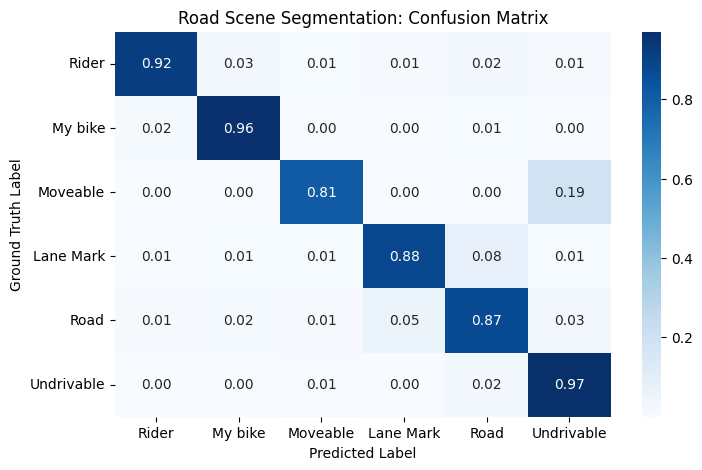


⚠️ Safety Risk Analysis: Best mIoU Model

=== [Safety-Critical Analysis] ===
--- 고위험 ---
1. 즉각적인 충돌 위험 - 'Undrivable' 영역의 1.91%가 'Road'로 오분류 됨.
2. 이동 물체 충돌 위험 - 'Moveable' 객체의 18.60%가 'Undrivable'로 오분류 됨.
3. 이동 물체 충돌 위험 - 'Moveable' 객체의 0.27%가 'Road'로 오분류 됨.
4. 시스템 오작동 유발 - 'Rider' 객체의 1.15%가 'Undrivable'로 오분류 됨.

--- 중위험 ---
5. 경로 계획 오류 - 'Road' 영역의 3.17%가 'Undrivable'로 오분류 됨.
6. 차선 유지 보조 오류 - 'Lane Mark' 영역의 8.14%가 'Road'로 오분류 됨.

--- 낮은-중간 위험 ---
7. 자기 인식 오류 - 'Rider' 객체의 2.62%가 'My bike'로 오분류 됨.


🚀 Starting Safety Evaluation for: Best mBoU Model...


Evaluating Best mBoU Model:   0%|          | 0/5 [00:00<?, ?it/s]


📊 Confusion Matrix: Best mBoU Model


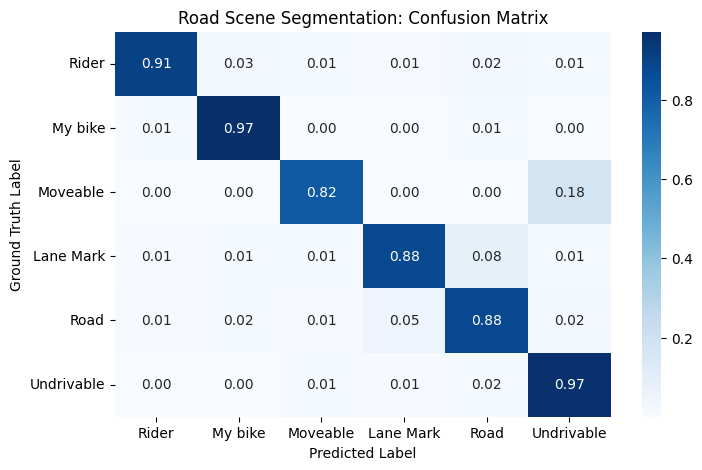


⚠️ Safety Risk Analysis: Best mBoU Model

=== [Safety-Critical Analysis] ===
--- 고위험 ---
1. 즉각적인 충돌 위험 - 'Undrivable' 영역의 1.75%가 'Road'로 오분류 됨.
2. 이동 물체 충돌 위험 - 'Moveable' 객체의 17.60%가 'Undrivable'로 오분류 됨.
3. 이동 물체 충돌 위험 - 'Moveable' 객체의 0.24%가 'Road'로 오분류 됨.
4. 시스템 오작동 유발 - 'Rider' 객체의 1.02%가 'Undrivable'로 오분류 됨.

--- 중위험 ---
5. 경로 계획 오류 - 'Road' 영역의 2.43%가 'Undrivable'로 오분류 됨.
6. 차선 유지 보조 오류 - 'Lane Mark' 영역의 8.38%가 'Road'로 오분류 됨.

--- 낮은-중간 위험 ---
7. 자기 인식 오류 - 'Rider' 객체의 3.14%가 'My bike'로 오분류 됨.


In [76]:
# Define the path to the saved checkpoints
CHECKPOINTS_DIR = "./checkpoints"

# Recreate the model architecture (it must be the same as during training)
# The configuration `CFG['model_name']`, `id2label`, `label2id`, `num_labels` are from previous cells.

# Model for Best mIoU
model_best_miou = SegformerForSemanticSegmentation.from_pretrained(
    CFG['model_name'],
    num_labels=len(id_to_idx),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
).to(CFG['device'])

# Load the state dictionary for the best mIoU model
miou_checkpoint_path = os.path.join(CHECKPOINTS_DIR, "segformer_best_miou.pth")
model_best_miou.load_state_dict(torch.load(miou_checkpoint_path, map_location=CFG['device']))
model_best_miou.eval()

# Model for Best mBoU
model_best_mbou = SegformerForSemanticSegmentation.from_pretrained(
    CFG['model_name'],
    num_labels=len(id_to_idx),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
).to(CFG['device'])

# Load the state dictionary for the best mBoU model
mbou_checkpoint_path = os.path.join(CHECKPOINTS_DIR, "segformer_best_mbou.pth")
model_best_mbou.load_state_dict(torch.load(mbou_checkpoint_path, map_location=CFG['device']))
model_best_mbou.eval()

# Call the profiling function for model_best_miou
profile_model(model_best_miou, CFG['img_size'], CFG['device'])

print("\n" + "="*50 + "\n") # Separator for clarity

# Call the profiling function for model_best_mbou
profile_model(model_best_mbou, CFG['img_size'], CFG['device'])

# Run safety evaluation for model_best_miou
run_safety_evaluation(
    model_best_miou,
    "Best mIoU Model",
    test_loader,
    CFG['device'],
    CFG_EVAL['num_classes'],
    id2label
)

print("\n" + "="*50 + "\n") # Separator for clarity

# Run safety evaluation for model_best_mbou
run_safety_evaluation(
    model_best_mbou,
    "Best mBoU Model",
    test_loader,
    CFG['device'],
    CFG_EVAL['num_classes'],
    id2label
)

Loading weights:   0%|          | 0/380 [00:00<?, ?it/s]

🚀 Evaluating Base Model...


100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


🚀 Evaluating LossZero Model...


100%|██████████| 5/5 [00:01<00:00,  2.89it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1849315..2.5241382].



Class Name      | Base Model IoU  | LossZero IoU    | Gain
-----------------------------------------------------------------
Rider           | 0.0000           | 0.8479           | +0.8479
My bike         | 0.0000           | 0.9256           | +0.9256
Moveable        | 0.1238           | 0.7027           | +0.5789
Lane Mark       | 0.0000           | 0.3506           | +0.3506
Road            | 0.5696           | 0.8270           | +0.2574
Undrivable      | 0.8384           | 0.9308           | +0.0924
-----------------------------------------------------------------
MEAN IoU        | 0.2553           | 0.7641           | +0.5088


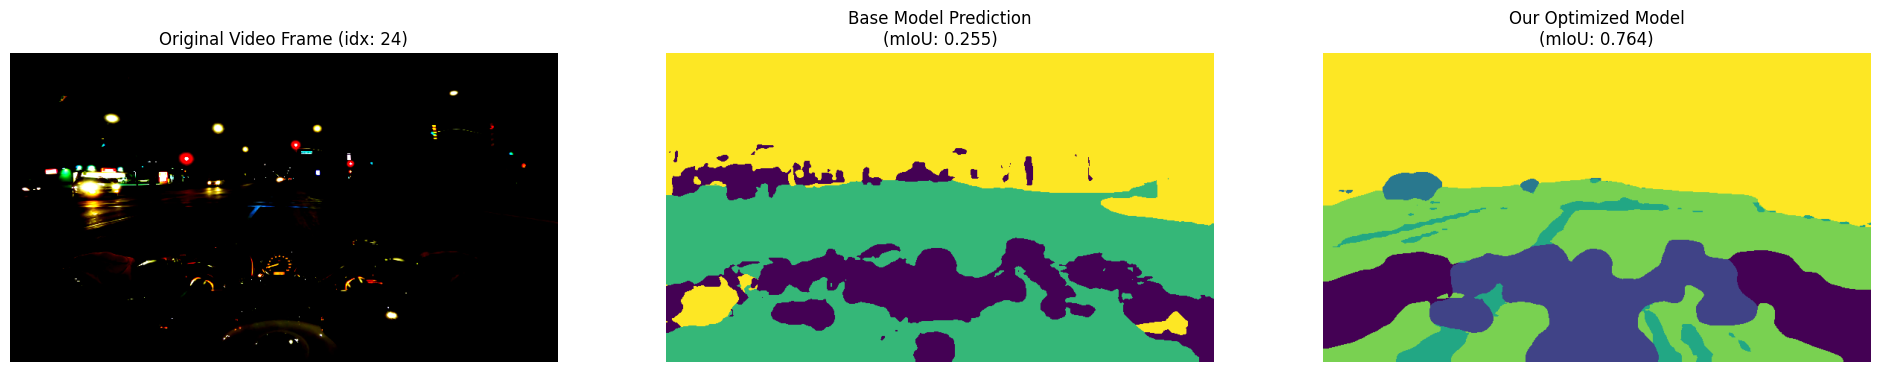

In [77]:
# ==========================================================
# 📊 OBJECTIVE EVALUATION: Base Model vs. LossZero Optimized
# ==========================================================
import torch
import torch.nn.functional as F
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import SegformerForSemanticSegmentation

def evaluate_model_metrics(model, loader, device, num_classes, is_base_model=False):
    model.eval()
    
    # Cityscapes(19) -> LossZero(6) Class Mapping
    # (Only needed for Base Model comparison)
    mapping = {
        0: 4,  # road -> Road
        1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, # static -> Undrivable
        11: 2, 12: 2, 13: 2, 14: 2, 15: 2, 16: 2, 17: 2, 18: 2      # dynamic -> Moveable
    }

    intersection = np.zeros(num_classes)
    union = np.zeros(num_classes)

    print(f"🚀 Evaluating {'Base Model' if is_base_model else 'LossZero Model'}...")
    with torch.no_grad():
        for images, masks in tqdm(loader):
            images = images.to(device)
            target = masks.numpy()
            
            outputs = model(images).logits
            upsampled = F.interpolate(outputs, size=target.shape[-2:], mode='bilinear', align_corners=False)
            preds = upsampled.argmax(dim=1).cpu().numpy()

            if is_base_model:
                # Map Cityscapes classes to our 6 classes
                mapped_preds = np.zeros_like(preds)
                for city_id, our_id in mapping.items():
                    mapped_preds[preds == city_id] = our_id
                preds = mapped_preds

            for cls in range(num_classes):
                pred_inds = preds == cls
                target_inds = target == cls
                intersection[cls] += np.logical_and(pred_inds, target_inds).sum()
                union[cls] += np.logical_or(pred_inds, target_inds).sum()

    iou_per_class = intersection / (union + 1e-9)
    miou = np.mean(iou_per_class)
    return iou_per_class, miou

# 1. 모델 준비
base_model_name = "nvidia/segformer-b2-finetuned-cityscapes-1024-1024"
base_model = SegformerForSemanticSegmentation.from_pretrained(base_model_name).to(CFG['device'])

# 2. 객관적 지표 계산 (Test 데이터셋 기준)
base_ious, base_miou = evaluate_model_metrics(base_model, test_loader, CFG['device'], 6, is_base_model=True)
our_ious, our_miou = evaluate_model_metrics(model_best_miou, test_loader, CFG['device'], 6, is_base_model=False)

# 3. 결과 테이블 출력
print("\n" + "="*65)
print(f"{'Class Name':<15} | {'Base Model IoU':<15} | {'LossZero IoU':<15} | {'Gain'}")
print("-" * 65)
for i, name in id2label.items():
    gain = our_ious[i] - base_ious[i]
    print(f"{name:<15} | {base_ious[i]:.4f}{' ':<10} | {our_ious[i]:.4f}{' ':<10} | {gain:+.4f}")
print("-" * 65)
print(f"{'MEAN IoU':<15} | {base_miou:.4f}{' ':<10} | {our_miou:.4f}{' ':<10} | {our_miou - base_miou:+.4f}")
print("="*65)

# 4. 시각적 증거 (Side-by-Side Visualization)
random_idx = random.randint(0, len(val_dataset) - 1)
image, mask = val_dataset[random_idx]
input_tensor = image.unsqueeze(0).to(CFG['device'])

with torch.no_grad():
    our_logits = model_best_miou(input_tensor).logits
    our_mask = F.interpolate(our_logits, size=image.shape[-2:], mode='bilinear').argmax(dim=1)[0].cpu().numpy()
    
    base_logits = base_model(input_tensor).logits
    base_raw = F.interpolate(base_logits, size=image.shape[-2:], mode='bilinear').argmax(dim=1)[0].cpu().numpy()
    
    # Visualization Mapping
    mapping = {0: 4, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 2, 12: 2, 13: 2, 14: 2, 15: 2, 16: 2, 17: 2, 18: 2}
    base_mapped = np.vectorize(lambda x: mapping.get(x, 5))(base_raw)

fig, axes = plt.subplots(1, 3, figsize=(24, 7))
axes[0].imshow(image.permute(1, 2, 0).cpu().numpy())
axes[0].set_title(f"Original Video Frame (idx: {random_idx})")
axes[1].imshow(base_mapped, cmap='viridis')
axes[1].set_title(f"Base Model Prediction\n(mIoU: {base_miou:.3f})")
axes[2].imshow(our_mask, cmap='viridis')
axes[2].set_title(f"Our Optimized Model\n(mIoU: {our_miou:.3f})")
for ax in axes: ax.axis('off')
plt.show()


/var/folders/ng/j7c3wxhn0lnclyqt41g9tcq80000gn/T/ipykernel_71897/540813472.py:77: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/ng/j7c3wxhn0lnclyqt41g9tcq80000gn/T/ipykernel_71897/540813472.py:77: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


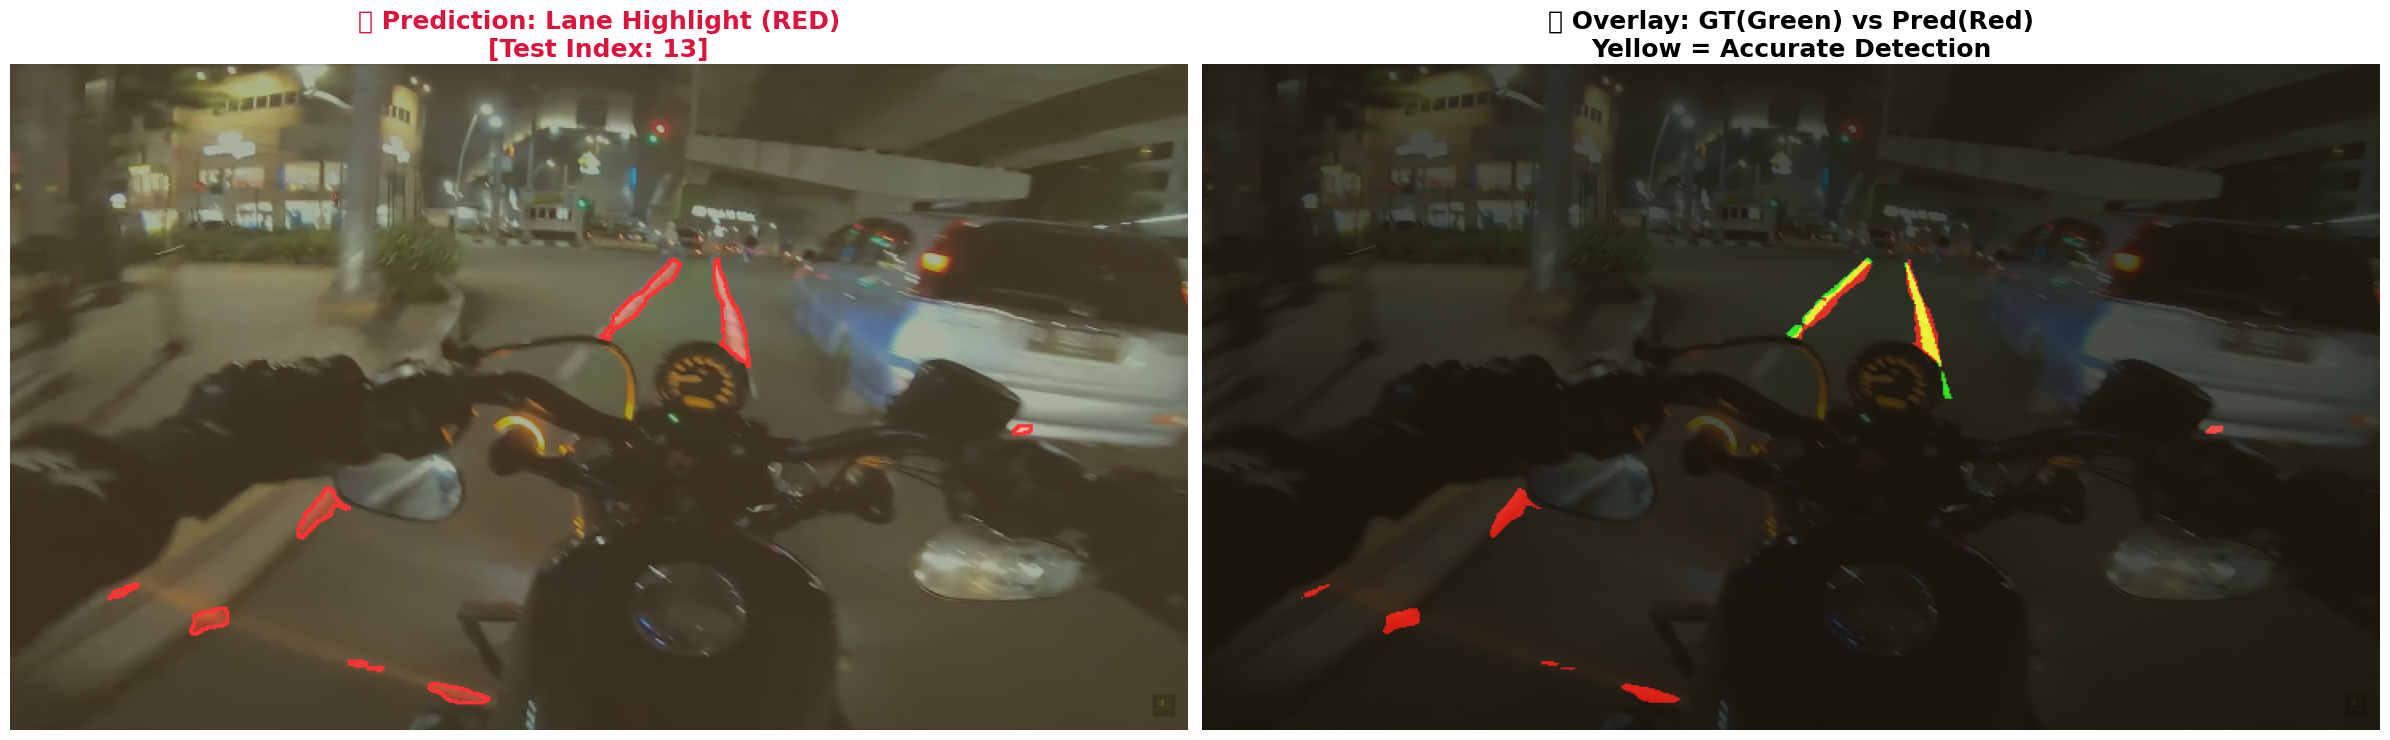

✅ Target Class: Lane Mark (Index 3)
📊 Pred Pixels: 1,904 | GT Pixels: 709


In [79]:
# 🔍 [V3] 테스트 이미지 추론: 차선(Lane Mark) 빨간색 하이라이트 완성형
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import cv2

# 1. 데이터셋 확인 및 이미지 선택
device = CFG['device']
model_to_use = model_best_miou if 'model_best_miou' in locals() else model
model_to_use.eval()

# 테스트 데이터셋에서 무작위 선택 (데이터가 충분한지 확인)
if 'test_dataset' in locals() and len(test_dataset) > 0:
    idx = random.randint(0, len(test_dataset) - 1)
    image_tensor, gt_mask = test_dataset[idx]
    
    # 2. 추론 (Forward Pass)
    input_batch = image_tensor.unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model_to_use(input_batch).logits
        # 원본 이미지 크기에 맞게 업샘플링
        upsampled = F.interpolate(outputs, size=image_tensor.shape[-2:], mode='bilinear', align_corners=False)
        pred_mask = upsampled.argmax(dim=1)[0].cpu().numpy()

    # 3. 시각화용 이미지 복원 (De-normalization)
    img_np = image_tensor.permute(1, 2, 0).cpu().numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_rgb = np.clip(img_np * std + mean, 0, 1)

    # 4. 차선(Lane Mark: 인덱스 3) 마스크 추출
    # 💡 id2label 확인: {3: 'Lane Mark'} 인지 체크
    target_cls = 3 
    pred_lane = (pred_mask == target_cls)
    gt_lane = (gt_mask.cpu().numpy() == target_cls)

    # 5. 결과 시각화 (HUD 스타일)
    plt.figure(figsize=(24, 10))

    # [Panel 1] 원본 이미지 + 예측 차선 하이라이트 (빨간색)
    plt.subplot(1, 2, 1)
    overlay = img_rgb.copy()
    # 차선 영역에 선명한 빨간색 오버레이 (네온 효과를 위해 alpha 채널처럼 합성)
    red_mask = np.zeros_like(img_rgb)
    red_mask[pred_lane] = [1.0, 0.0, 0.0]
    
    # 엣지(경계선)를 추출하여 더 선명하게 표시
    kernel = np.ones((3,3), np.uint8)
    lane_edge = cv2.morphologyEx(pred_lane.astype(np.uint8), cv2.MORPH_GRADIENT, kernel)
    
    combined = cv2.addWeighted(img_rgb, 0.7, red_mask, 0.3, 0)
    combined[lane_edge > 0] = [1.0, 0.2, 0.2] # 경계선은 더 밝은 빨강으로 강조
    
    plt.imshow(combined)
    plt.title(f"🚀 Prediction: Lane Highlight (RED)\n[Test Index: {idx}]", fontsize=18, fontweight='bold', color='crimson')
    plt.axis('off')

    # [Panel 2] 정답(Ground Truth) vs 예측(Prediction) 비교
    plt.subplot(1, 2, 2)
    comparison = np.zeros_like(img_rgb)
    # GT는 초록색, Pred는 빨간색으로 표시하여 겹치는 부분 확인
    comparison[gt_lane] = [0.0, 1.0, 0.0] # GT: Green
    comparison[pred_lane] = [1.0, 0.0, 0.0] # Pred: Red
    # 둘 다 있으면 노란색 (중첩 영역)
    overlap = gt_lane & pred_lane
    comparison[overlap] = [1.0, 1.0, 0.0] # Overlap: Yellow
    
    # 배경에 희미하게 원본 이미지 깔기
    final_comp = cv2.addWeighted(img_rgb, 0.3, comparison, 0.7, 0)
    
    plt.imshow(final_comp)
    plt.title("📍 Overlay: GT(Green) vs Pred(Red)\nYellow = Accurate Detection", fontsize=18, fontweight='bold')
    plt.axis('off')

    plt.tight_layout()
    plt.savefig('lane_inference_hud.png', bbox_inches='tight')
    plt.show()

    # 클래스 정보 요약
    if 'id2label' in locals():
        print(f"✅ Target Class: {id2label[target_cls]} (Index {target_cls})")
        print(f"📊 Pred Pixels: {np.sum(pred_lane):,} | GT Pixels: {np.sum(gt_lane):,}")
else:
    print("⚠️ test_dataset이 정의되지 않았거나 비어있습니다.")
